In [ ]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# from IPython.display import display
from matplotlib import cm
%matplotlib notebook
from keras.models import Sequential
from keras.layers.core import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

#Import dataset
df = pd.read_pickle('DoE_results_3d_1k.pkl')
points_df = df['points']

#Eliminate all NaN output values 
points_df_1 = points_df[(points_df['sigma_crit'] > 0) & (points_df['energy'] >= 0)]
sigma_crit_1 = points_df_1['sigma_crit']
energy_1 = points_df_1['energy']

#Find the quartiles to eliminate outliers
q1_s = np.percentile(sigma_crit_1,25.0)
q3_s = np.percentile(sigma_crit_1, 75.0)
q1_e = np.percentile(energy_1,25.0)
q3_e = np.percentile(energy_1, 75.0)

#Define the highest point which is not considered an outlier
high_s = q3_s + 1.5*(q3_s-q1_s)
high_e = q3_e + 1.5*(q3_e-q1_e)

#Eliminate outliers
points_df_2 = points_df[(points_df['sigma_crit'] < high_s) & (points_df['energy'] < high_e)]

#Convert the columns to arrays
RD = points_df_2[['ratio_d']].to_numpy()
RP = points_df_2[['ratio_pitch']].to_numpy()
RT = points_df_2[['ratio_top_diameter']].to_numpy()
S  = points_df_2[['sigma_crit']].to_numpy()
E  = points_df_2[['energy']].to_numpy()

input1 = RD
input2 = RP
input3 = RT
output = E


X_data = np.array([input1,input2, input3]).reshape(3,-1).T
Y_data = np.array([output]).reshape(-1,1)
xx1, xx2, xx3 = np.meshgrid(input1,input2, input3, sparse=True)
yy1 = output

train_size= 0.70
X_Train,X_Test,Y_Train,Y_Test=train_test_split(X_data, Y_data, train_size=train_size)

In [ ]:

def create_model (input_dimensions=3, neurons1=1, neurons2=1,neurons3=1, neurons4=1, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(Dense(neurons1, input_dim=input_dimensions, activation=activation))
    model.add(Dense(neurons2, activation=activation))
    model.add(Dense(neurons3, activation=activation))
    model.add(Dense(neurons4, activation=activation))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=optimizer)
    return model


gridsearch = 0

if gridsearch==1:
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=30, mode='min')
    neurons1=[100]
    neurons2=[50]
    neurons3=[20,30,40,50,60,70]
    neurons4=[60]
    batch_size=[len(X_Train)]
    epochs=[1000]
    optimizer=['adam']
    
    param_grid = dict(batch_size=batch_size, epochs=epochs, neurons1=neurons1, neurons2=neurons2, neurons3=neurons3, neurons4=neurons4, optimizer=optimizer )
    NN_model = KerasRegressor(build_fn=create_model, input_dimensions=np.shape(X_Train)[1])
    
    grid=GridSearchCV(estimator=NN_model, param_grid=param_grid, n_jobs=1, cv=3, iid= False )
    
    grid_result = grid.fit(X_Train, Y_Train, callbacks=[early_stopping], validation_data=(X_Test, Y_Test))
    
    history = grid_result.best_estimator_.fit(X_Train, Y_Train,callbacks=[early_stopping], validation_data=(X_Test, Y_Test))
    
    #print("Best: %f using %s1" % (grid_result.best_score, grid_result.best_params))
    
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
else:
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=40, mode='min')
    neurons1=100
    neurons2=50
    neurons3=40
    neurons4=60

    NN_model = KerasRegressor(build_fn=create_model, neurons1=neurons1, neurons2=neurons2, neurons3=neurons3, neurons4=neurons4, batch_size=len(X_Train), epochs=1000, optimizer='adam', callbacks=[early_stopping],validation_data=(X_Test, Y_Test))
    history = NN_model.fit(X_Train, Y_Train)


Train on 351 samples, validate on 151 samples
Epoch 1/1000
351/351 [==============================] - 0s 359us/step - loss: 173.7099 - val_loss: 196.1291
Epoch 2/1000
351/351 [==============================] - 0s 12us/step - loss: 173.3231 - val_loss: 195.7703
Epoch 3/1000
351/351 [==============================] - 0s 13us/step - loss: 172.9711 - val_loss: 195.4457
Epoch 4/1000
351/351 [==============================] - 0s 20us/step - loss: 172.6524 - val_loss: 195.1404
Epoch 5/1000
351/351 [==============================] - 0s 13us/step - loss: 172.3552 - val_loss: 194.8367
Epoch 6/1000
351/351 [==============================] - 0s 12us/step - loss: 172.0589 - val_loss: 194.5466
Epoch 7/1000
351/351 [==============================] - 0s 12us/step - loss: 171.7753 - val_loss: 194.2689
Epoch 8/1000
351/351 [==============================] - 0s 13us/step - loss: 171.5059 - val_loss: 193.9997
Epoch 9/1000
351/351 [==============================] - 0s 18us/step - loss: 171.2436 - val_loss:

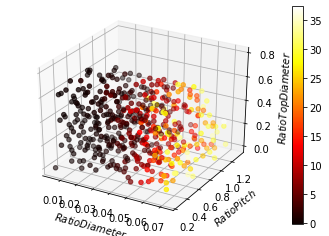

In [ ]:
 %matplotlib inline
fig3 = plt.figure()
ax3 = fig3.add_subplot(111, projection='3d')

y_pred = history.model.predict(X_data)
y_data_pred = y_pred

yy1_data_pred = np.reshape(y_data_pred,np.shape(xx1))

ax3.set_xlabel('$Ratio Diameter$')
ax3.set_ylabel('$Ratio Pitch$')
ax3.set_zlabel('$Ratio Top Diameter$')

img = ax3.scatter(xx1,xx2,xx3,c=yy1_data_pred, cmap=plt.hot())
fig3.colorbar(img)
plt.show()

In [ ]:
mse_value = mean_squared_error(output, y_data_pred)
r2_value  = r2_score(output, y_data_pred)
print('MSE', mse_value)
print('R2', r2_value)

MSE 0.2402513806200554
R2 0.9977067776424245


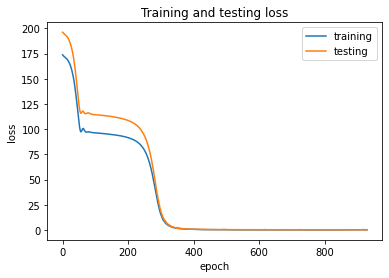

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and testing loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'testing'], loc='upper right')
plt.show()





/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


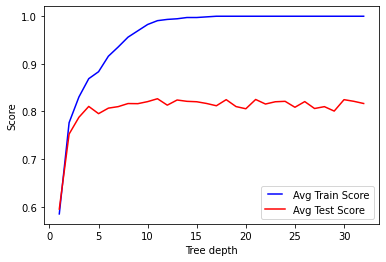

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classificat

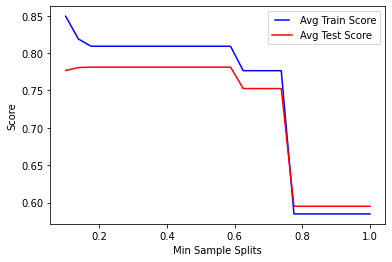

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classificat

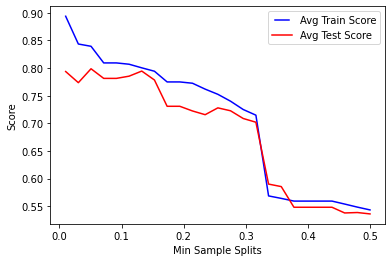

In [ ]:
# 3D dataset with 3 different classifiers coilable, yields and non coilable
# Hyperparameters influence
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support
from matplotlib.legend_handler import HandlerLine2D

data = pd.read_pickle('DoE_results_3d_1k.pkl')
data_df = data['points']

feature_names = data_df.columns.values[0:3] # not including the "ID" column
X = data_df.iloc[:, 0:3 ].values  #get all the 3d variables
y_string = data_df.loc[:, 'coilable'].values
y = pd.Categorical(pd.factorize(y_string)[0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

# Max Tree Depth
max_depths = np.linspace(1, 32, 32, endpoint=True)
scores0 = []
scores1 = []

for max_depth in max_depths:
  dt = DecisionTreeClassifier(max_depth=max_depth)
  dt.fit(X_train, y_train)
  train_pred = dt.predict(X_train)
  trest_pred = dt.predict(X_test)

  #Calculate scores
  scoreTrain = precision_recall_fscore_support(y_train, train_pred, average='weighted')
  scoreTest = precision_recall_fscore_support(y_test, trest_pred, average='weighted')
  avgTrain = (scoreTrain[0] + scoreTrain[1] + scoreTrain[2]) / 3
  avgTest = (scoreTest[0] + scoreTest[1] + scoreTest[2]) / 3

  # Add score to respecive scores
  scores0.append(avgTrain)
  scores1.append(avgTest)

line1, = plt.plot(max_depths, scores0, 'b', label="Avg Train Score")
line2, = plt.plot(max_depths, scores1, 'r', label="Avg Test Score")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Score')
plt.xlabel('Tree depth')
plt.show()

# Min Sample Splits
min_samples_splits = np.linspace(0.1, 1.0, 25, endpoint=True)
scores0 = []
scores1 = []

for min_samples_split in min_samples_splits:
  dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
  dt.fit(X_train, y_train)
  train_pred = dt.predict(X_train)
  trest_pred = dt.predict(X_test)

  #Calculate scores
  scoreTrain = precision_recall_fscore_support(y_train, train_pred, average='weighted')
  scoreTest = precision_recall_fscore_support(y_test, trest_pred, average='weighted')
  avgTrain = (scoreTrain[0] + scoreTrain[1] + scoreTrain[2]) / 3
  avgTest = (scoreTest[0] + scoreTest[1] + scoreTest[2]) / 3

  # Add score to respecive scores
  scores0.append(avgTrain)
  scores1.append(avgTest)

line1, = plt.plot(min_samples_splits, scores0, 'b', label="Avg Train Score")
line2, = plt.plot(min_samples_splits, scores1, 'r', label="Avg Test Score")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Score')
plt.xlabel('Min Sample Splits')
plt.show()


# Min Smaple Leafs
min_samples_leafs = np.linspace(0.01, 0.5, 25, endpoint=True)
scores0 = []
scores1 = []

for min_samples_leaf in min_samples_leafs:
  dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
  dt.fit(X_train, y_train)
  train_pred = dt.predict(X_train)
  trest_pred = dt.predict(X_test)

  #Calculate scores
  scoreTrain = precision_recall_fscore_support(y_train, train_pred, average='weighted')
  scoreTest = precision_recall_fscore_support(y_test, trest_pred, average='weighted')
  avgTrain = (scoreTrain[0] + scoreTrain[1] + scoreTrain[2]) / 3
  avgTest = (scoreTest[0] + scoreTest[1] + scoreTest[2]) / 3

  # Add score to respecive scores
  scores0.append(avgTrain)
  scores1.append(avgTest)

line1, = plt.plot(min_samples_leafs, scores0, 'b', label="Avg Train Score")
line2, = plt.plot(min_samples_leafs, scores1, 'r', label="Avg Test Score")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Score')
plt.xlabel('Min Sample Splits')
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


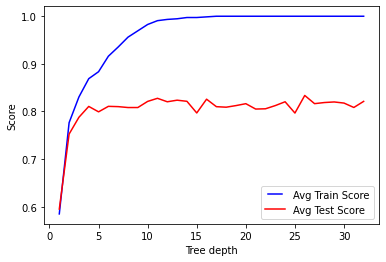

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classificat

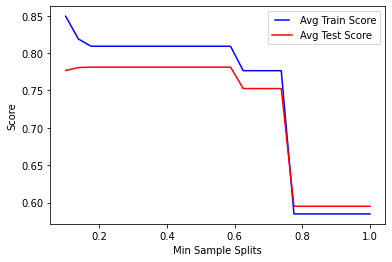

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classificat

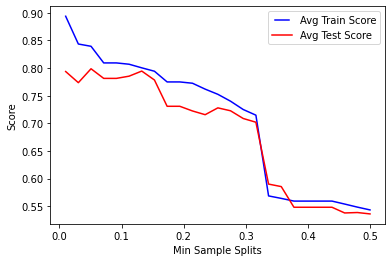

In [ ]:
# 3D dataset with 3 different classifiers coilable, yields and non coilable
# Hyperparameters influence
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support
from matplotlib.legend_handler import HandlerLine2D

data = pd.read_pickle('DoE_results_3d_1k.pkl')
data_df = data['points']

feature_names = data_df.columns.values[0:3] # not including the "ID" column
X = data_df.iloc[:, 0:3 ].values  #get all the 3d variables
y_string = data_df.loc[:, 'coilable'].values
y = pd.Categorical(pd.factorize(y_string)[0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

# Max Tree Depth
max_depths = np.linspace(1, 32, 32, endpoint=True)
scores0 = []
scores1 = []

for max_depth in max_depths:
  dt = DecisionTreeClassifier(max_depth=max_depth)
  dt.fit(X_train, y_train)
  train_pred = dt.predict(X_train)
  trest_pred = dt.predict(X_test)

  #Calculate scores
  scoreTrain = precision_recall_fscore_support(y_train, train_pred, average='weighted')
  scoreTest = precision_recall_fscore_support(y_test, trest_pred, average='weighted')
  avgTrain = (scoreTrain[0] + scoreTrain[1] + scoreTrain[2]) / 3
  avgTest = (scoreTest[0] + scoreTest[1] + scoreTest[2]) / 3

  # Add score to respecive scores
  scores0.append(avgTrain)
  scores1.append(avgTest)

line1, = plt.plot(max_depths, scores0, 'b', label="Avg Train Score")
line2, = plt.plot(max_depths, scores1, 'r', label="Avg Test Score")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Score')
plt.xlabel('Tree depth')
plt.show()

# Min Sample Splits
min_samples_splits = np.linspace(0.1, 1.0, 25, endpoint=True)
scores0 = []
scores1 = []

for min_samples_split in min_samples_splits:
  dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
  dt.fit(X_train, y_train)
  train_pred = dt.predict(X_train)
  trest_pred = dt.predict(X_test)

  #Calculate scores
  scoreTrain = precision_recall_fscore_support(y_train, train_pred, average='weighted')
  scoreTest = precision_recall_fscore_support(y_test, trest_pred, average='weighted')
  avgTrain = (scoreTrain[0] + scoreTrain[1] + scoreTrain[2]) / 3
  avgTest = (scoreTest[0] + scoreTest[1] + scoreTest[2]) / 3

  # Add score to respecive scores
  scores0.append(avgTrain)
  scores1.append(avgTest)

line1, = plt.plot(min_samples_splits, scores0, 'b', label="Avg Train Score")
line2, = plt.plot(min_samples_splits, scores1, 'r', label="Avg Test Score")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Score')
plt.xlabel('Min Sample Splits')
plt.show()


# Min Smaple Leafs
min_samples_leafs = np.linspace(0.01, 0.5, 25, endpoint=True)
scores0 = []
scores1 = []

for min_samples_leaf in min_samples_leafs:
  dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
  dt.fit(X_train, y_train)
  train_pred = dt.predict(X_train)
  trest_pred = dt.predict(X_test)

  #Calculate scores
  scoreTrain = precision_recall_fscore_support(y_train, train_pred, average='weighted')
  scoreTest = precision_recall_fscore_support(y_test, trest_pred, average='weighted')
  avgTrain = (scoreTrain[0] + scoreTrain[1] + scoreTrain[2]) / 3
  avgTest = (scoreTest[0] + scoreTest[1] + scoreTest[2]) / 3

  # Add score to respecive scores
  scores0.append(avgTrain)
  scores1.append(avgTest)

line1, = plt.plot(min_samples_leafs, scores0, 'b', label="Avg Train Score")
line2, = plt.plot(min_samples_leafs, scores1, 'r', label="Avg Test Score")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Score')
plt.xlabel('Min Sample Splits')
plt.show()

In [ ]:
# Train baseline
base = DecisionTreeClassifier().fit(X_train, y_train)   # Decision Tree

# Predict using Decision Tree
Ybase = base.predict(X_test)         # Decision Tree

# Hyperparamter optimization
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {"max_depth": [3, None],
              "min_samples_split": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

hyper_tree = DecisionTreeClassifier()
hyper_tree_cv = RandomizedSearchCV(hyper_tree, param_dist, cv=100)

hyper_tree_cv.fit(X_train, y_train)

Yhyper = hyper_tree_cv.predict(X_test)

print('\t\t precision \t\t recall \t f1')
print('Baseline\t', precision_recall_fscore_support(y_test, Ybase, average='weighted'))
print('Optimized\t', precision_recall_fscore_support(y_test, Yhyper, average='weighted'))
print("Tuned Decision Tree Parameters: {}".format(hyper_tree_cv.best_params_))
print("Best score is {}".format(hyper_tree_cv.best_score_))

		 precision 		 recall 	 f1
Baseline	 (0.8122707535121328, 0.812, 0.8119743075070253, None)
Optimized	 (0.7884067355110642, 0.788, 0.7876670874885618, None)
Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 7, 'min_samples_split': 8}
Best score is 0.8298214285714286


In [ ]:
# 3D dataset with 3 different classifiers coilable, yields and non coilable
# Hyperparameters influence
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support
from mpl_toolkits.mplot3d import Axes3D

data = pd.read_pickle('DoE_results_3d_1k.pkl')
data_df = data['points']

feature_names = data_df.columns.values[0:3] # not including the "ID" column
X = data_df.iloc[:, 0:3 ].values  #get all the 3d variables
y_string = data_df.loc[:, 'coilable'].values
y = pd.Categorical(pd.factorize(y_string)[0]) #0 coilaible, 1 non coilable, 2 yields

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

plot_colors = "ryb"
plot_step = 0.02

# Train
clfDT = DecisionTreeClassifier().fit(X_train, y_train)   # Decision Tree

# Predict using Decision Tree
YDT = clfDT.predict(X_test)         # Decision Tree
print('\t\t precision \t\t recall \t f1')
print('Prediction:\t', precision_recall_fscore_support(y_test, YDT, average='weighted'))

# Set the scale correctly
x1_min, x1_max = X_train[:, 0].min() - 0, X_train[:, 0].max() + 0
x2_min, x2_max = X_train[:, 1].min() - 0, X_train[:, 1].max() + 0
x3_min, x3_max = X_train[:, 2].min() - 0, X_train[:, 2].max() + 0
# Make a set of variables within the bounds of the original variables
xx1, xx2, xx3 = np.meshgrid(np.arange(x1_min, x1_max, plot_step),
                      np.arange(x2_min, x2_max, plot_step),
                      np.arange(x3_min, x3_max, plot_step))
X_general = np.c_[xx1.ravel(), xx2.ravel(), xx3.ravel()]

# Predict using the Classifier for all the variables
Y_general = clfDT.predict(X_general)  # Decision Tree

j = 0
k = 0
X_coilable = []
print(X_general[10])

for i in Y_general:
  if i == 0:  # coilable data
    X_coilable.append(X_general[j])
    k = k + 1
  j = j + 1

X_coilable

		 precision 		 recall 	 f1
Prediction:	 (0.8139649617078687, 0.812, 0.8128578478464913, None)
[0.004 0.25  0.2  ]


[array([0.004, 0.25 , 0.   ]),
 array([0.004, 0.25 , 0.02 ]),
 array([0.004, 0.25 , 0.04 ]),
 array([0.004, 0.25 , 0.06 ]),
 array([0.004, 0.25 , 0.08 ]),
 array([0.004, 0.25 , 0.1  ]),
 array([0.004, 0.25 , 0.12 ]),
 array([0.004, 0.25 , 0.14 ]),
 array([0.004, 0.25 , 0.16 ]),
 array([0.004, 0.25 , 0.18 ]),
 array([0.004, 0.25 , 0.2  ]),
 array([0.004, 0.25 , 0.22 ]),
 array([0.004, 0.25 , 0.24 ]),
 array([0.004, 0.25 , 0.26 ]),
 array([0.004, 0.25 , 0.28 ]),
 array([0.004, 0.25 , 0.3  ]),
 array([0.004, 0.25 , 0.32 ]),
 array([0.004, 0.25 , 0.34 ]),
 array([0.004, 0.25 , 0.36 ]),
 array([0.004, 0.25 , 0.38 ]),
 array([0.004, 0.25 , 0.4  ]),
 array([0.004, 0.25 , 0.42 ]),
 array([0.004, 0.25 , 0.44 ]),
 array([0.004, 0.25 , 0.46 ]),
 array([0.004, 0.25 , 0.48 ]),
 array([0.004, 0.25 , 0.5  ]),
 array([0.004, 0.25 , 0.52 ]),
 array([0.004, 0.25 , 0.54 ]),
 array([0.004, 0.25 , 0.56 ]),
 array([0.004, 0.25 , 0.58 ]),
 array([0.004, 0.25 , 0.6  ]),
 array([0.004, 0.25 , 0.62 ]),
 array([

In [ ]:
X_coilable_array = np.asarray(X_coilable)
y_coilable = history.model.predict(X_coilable_array)
maximum = y_coilable.max()
result = np.where(y_coilable == np.max(y_coilable))
y_max_pos = result[0]
x_max = X_coilable_array[y_max_pos[0]]
print('maximum:',maximum)
print('Inputs for maximum:',x_max)

maximum: 40.501865
Inputs for maximum: [0.064 0.75  0.64 ]
